### Creating a LSTM Model

In [1]:
from pymongo import MongoClient
import numpy as np
import os
import random
import tensorflow as tf
import pandas as pd
import pickle
from tqdm import tqdm 
import matplotlib.pyplot as plt
%matplotlib inline
tqdm.pandas()

In [2]:
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import LSTM , Dense , Flatten , Dropout , Input
from tensorflow.keras.callbacks import TensorBoard , EarlyStopping

In [3]:

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix , accuracy_score

In [4]:
from Create_dataset import actions

c:\Users\Sahil\AppData\Local\Programs\Python\Python312\python.exe
2.17.0
0.10.18


In [5]:
# File Path to store the landmark data

DATA_PATH = os.path.join("LANDMARK_DATA")

# Defining the actions 

actions = np.array(['hello' , 'thankyou' , 'iloveyou' , 'sorry' ,'A' , 'B' , 'C' , 'D' , 'E' , 'F'])
# Defining the number of videos per action

no_of_videos = 100

# Defining the number of frames per video

no_of_frames = 30

In [6]:

# Creating Label Map 

label_map = {label:num for num , label in enumerate(actions)}

In [7]:
label_map

{'hello': 0,
 'thankyou': 1,
 'iloveyou': 2,
 'sorry': 3,
 'A': 4,
 'B': 5,
 'C': 6,
 'D': 7,
 'E': 8,
 'F': 9}

In [8]:
tf.random.set_seed(17)
np.random.seed(17)
random.seed(17)

#### 1. Extracting Data from MongoDB

In [9]:
connection = MongoClient('localhost' , 27017)
db = connection['mydb']
collection = db['Preprocessed_Landmark_Data']

In [10]:
cursor = collection.find({})
df = pd.DataFrame(list(cursor))

In [11]:
df['Landmarks'] = df['Landmarks'].progress_apply(lambda landmarks : [np.array(x) if isinstance(x , list) else x for x in landmarks])

100%|██████████| 1600/1600 [00:14<00:00, 112.74it/s]


In [12]:
df['Landmarks'][0]

[array([ 0.5282082 ,  0.69970912, -0.78407443, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.55254889,  0.63023722, -0.78952068, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.55559933,  0.61130732, -0.7708981 , ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.56082523,  0.60821176, -0.77176523, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.56795919,  0.6058867 , -0.81826133, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.56992733,  0.60519606, -0.77989995, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.57354176,  0.60459828, -0.86566448, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.57485545,  0.60356939, -0.90603018, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.5737077 ,  0.60355467, -0.84255922, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.57421315,  0.60291201, -1.03197324, ...,  0.        ,
         0.        ,  0.  

In [13]:
X = np.array(df['Landmarks'].tolist())
labels_list = (df['Labels'].tolist())
y = to_categorical(labels_list).astype(int)


In [14]:
X.shape

(1600, 30, 1662)

In [15]:
y.shape

(1600, 10)

In [16]:
X

array([[[ 0.5282082 ,  0.69970912, -0.78407443, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.55254889,  0.63023722, -0.78952068, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.55559933,  0.61130732, -0.7708981 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.62980717,  0.59732503, -1.28325009, ...,  0.47731709,
          0.40780509, -0.02713273],
        [ 0.63064581,  0.59841526, -1.25939536, ...,  0.48286542,
          0.40332043, -0.03363072],
        [ 0.62974828,  0.59842288, -1.20764422, ...,  0.44305485,
          0.3869282 , -0.03627616]],

       [[ 0.62721896,  0.59237534, -1.21063435, ...,  0.39933065,
          0.32641381, -0.06619024],
        [ 0.62298107,  0.5921942 , -1.05823302, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.62047112,  0.59255719, -1.09682631, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.53934711,  0.60268617, -0.99255943, ...,  

#### 2. Performing Train-test split
- using 95-5  percent train-test split

In [17]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.05)

In [18]:
print("X-train shape:" , X_train.shape)
print("X-test shape:" , X_test.shape)
print("y-train shape:" , y_train.shape)
print("y-test shape:" , y_test.shape)

X-train shape: (1520, 30, 1662)
X-test shape: (80, 30, 1662)
y-train shape: (1520, 10)
y-test shape: (80, 10)


Creating LSTM Model Architecture

In [19]:
# Creating a Instance of Early Stopping

early_stopping_callback = EarlyStopping(
 monitor = 'val_loss',
 patience = 5,
 mode = 'min',
 restore_best_weights = True
)

In [20]:
X_train.shape

(1520, 30, 1662)

In [21]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)

In [22]:
# Constructing LSTM Model

LSTM_model = Sequential()
LSTM_model.add(LSTM(64, return_sequences= True , activation = 'relu' , input_shape = (30 , 1662)))
LSTM_model.add(LSTM(128 , return_sequences= True , activation = 'relu'))
# model.add(LSTM(128 , return_sequences= True , activation = 'relu'))
LSTM_model.add(LSTM(64 , return_sequences= False , activation='relu'))
# model.add(Dense(128 , activation ='relu'))
# model.add(Dense(64 , activation ='relu'))
LSTM_model.add(Dense(64 , activation ='relu'))
LSTM_model.add(Dense(32 , activation = 'relu'))
LSTM_model.add(Dense(actions.shape[0] , activation='softmax'))

c:\Users\Sahil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
LSTM_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 596,906 (2.28 MB)

 Trainable params: 596,906 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Compiling the Model 

LSTM_model.compile(optimizer='Adam' , loss = 'categorical_crossentropy' , metrics = ['categorical_accuracy'])

In [25]:
LSTM_model_history = LSTM_model.fit(X_train , y_train , epochs = 300 , validation_split= 0.2)

Epoch 1/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 486ms/step - categorical_accuracy: 0.2088 - loss: 4.3379 - val_categorical_accuracy: 0.2171 - val_loss: 2.1431
Epoch 2/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - categorical_accuracy: 0.2390 - loss: 2.0181 - val_categorical_accuracy: 0.2961 - val_loss: 2.0850
Epoch 3/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - categorical_accuracy: 0.3146 - loss: 1.9511 - val_categorical_accuracy: 0.1974 - val_loss: 2.4124
Epoch 4/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - categorical_accuracy: 0.2242 - loss: 2.2807 - val_categorical_accuracy: 0.1612 - val_loss: 2.2994
Epoch 5/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - categorical_accuracy: 0.2461 - loss: 2.1461 - val_categorical_accuracy: 0.2566 - val_loss: 2.1477
Epoch 6/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - categorical_accuracy: 0.3111 - loss: 2.0358 - val_categorical_accuracy: 0.3026 - val_loss: 1.9956
Epoch 7/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - categorical_accuracy: 0.3405 - l

Visualizing the outcomes

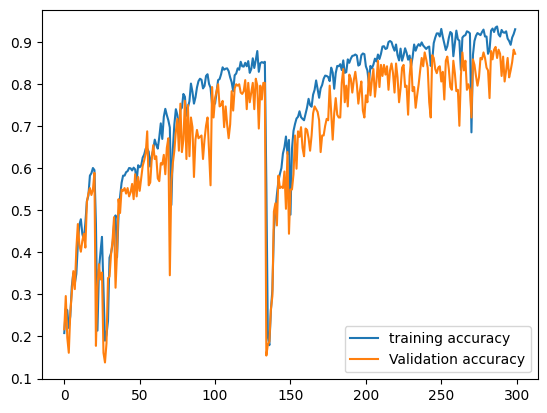

In [26]:
plt.plot(LSTM_model_history.history['categorical_accuracy'] , label = 'training accuracy')
plt.plot(LSTM_model_history.history['val_categorical_accuracy'] , label = 'Validation accuracy')
plt.legend(loc ='lower right')

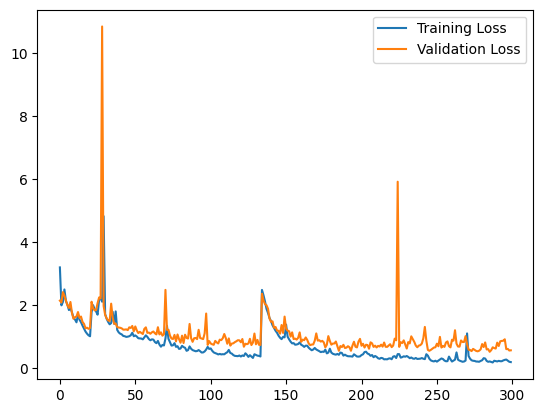

In [27]:
plt.plot(LSTM_model_history.history['loss'] , label = 'Training Loss')
plt.plot(LSTM_model_history.history['val_loss'] , label = 'Validation Loss')
plt.legend(loc = 'upper right')

In [28]:
LSTM_model.evaluate(X_test , y_test , verbose = 1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.9297 - loss: 0.3090


[0.24840405583381653, 0.9375]

#### 3. Predicting Results

In [29]:
predictions = LSTM_model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


In [30]:
predictions[0]

array([2.1412611e-22, 1.0000000e+00, 3.1647439e-13, 3.0113085e-16,
       8.5664508e-31, 2.0767603e-21, 6.0554071e-33, 3.1324997e-21,
       1.9341354e-15, 2.0738038e-32], dtype=float32)

In [31]:
actions[np.argmax(predictions[0])]

'thankyou'

In [32]:
actions[np.argmax(y_test[0])]

'thankyou'

In [33]:
results , actual = [] , []

for result in predictions:
  
  outcome = actions[np.argmax(result)]

  results.append(outcome)
  

for i in range(len(y_test)):

  act_out = actions[np.argmax(y_test[i])] 

  actual.append(act_out)


In [34]:
results

['thankyou',
 'hello',
 'C',
 'hello',
 'sorry',
 'hello',
 'thankyou',
 'hello',
 'thankyou',
 'A',
 'B',
 'sorry',
 'B',
 'thankyou',
 'sorry',
 'sorry',
 'thankyou',
 'hello',
 'hello',
 'thankyou',
 'E',
 'hello',
 'C',
 'hello',
 'sorry',
 'C',
 'iloveyou',
 'iloveyou',
 'E',
 'iloveyou',
 'hello',
 'B',
 'sorry',
 'thankyou',
 'hello',
 'hello',
 'iloveyou',
 'C',
 'hello',
 'iloveyou',
 'E',
 'A',
 'thankyou',
 'hello',
 'thankyou',
 'F',
 'A',
 'iloveyou',
 'iloveyou',
 'thankyou',
 'hello',
 'D',
 'thankyou',
 'sorry',
 'iloveyou',
 'thankyou',
 'iloveyou',
 'iloveyou',
 'iloveyou',
 'iloveyou',
 'B',
 'iloveyou',
 'E',
 'iloveyou',
 'F',
 'hello',
 'sorry',
 'hello',
 'thankyou',
 'hello',
 'hello',
 'hello',
 'hello',
 'B',
 'hello',
 'thankyou',
 'iloveyou',
 'thankyou',
 'hello',
 'thankyou']

In [35]:
actual

['thankyou',
 'hello',
 'C',
 'hello',
 'sorry',
 'hello',
 'thankyou',
 'hello',
 'thankyou',
 'A',
 'B',
 'sorry',
 'F',
 'thankyou',
 'sorry',
 'sorry',
 'thankyou',
 'hello',
 'iloveyou',
 'thankyou',
 'E',
 'hello',
 'C',
 'hello',
 'sorry',
 'C',
 'iloveyou',
 'iloveyou',
 'E',
 'iloveyou',
 'A',
 'B',
 'sorry',
 'thankyou',
 'hello',
 'hello',
 'iloveyou',
 'C',
 'hello',
 'iloveyou',
 'E',
 'A',
 'thankyou',
 'hello',
 'thankyou',
 'F',
 'A',
 'iloveyou',
 'iloveyou',
 'thankyou',
 'hello',
 'D',
 'thankyou',
 'sorry',
 'iloveyou',
 'thankyou',
 'iloveyou',
 'iloveyou',
 'iloveyou',
 'iloveyou',
 'C',
 'iloveyou',
 'E',
 'iloveyou',
 'F',
 'hello',
 'sorry',
 'hello',
 'thankyou',
 'hello',
 'hello',
 'hello',
 'hello',
 'F',
 'hello',
 'thankyou',
 'iloveyou',
 'thankyou',
 'hello',
 'thankyou']

In [36]:
type(results)

list

In [37]:
comparision_df = pd.DataFrame({'y_true' : actual , 'y_pred': results})

In [38]:
comparision_df

,y_true,y_pred
0,thankyou,thankyou
1,hello,hello
2,C,C
3,hello,hello
4,sorry,sorry
...,...,...
75,thankyou,thankyou
76,iloveyou,iloveyou
77,thankyou,thankyou
78,hello,hello


#### 4. Saving the model Weights

In [39]:
with open('LSTM_model' , 'wb') as file:
  pickle.dump(LSTM_model , file)

#### 5.Evaluation using Confusion Matrix and accuracy

In [40]:
y_hat = LSTM_model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [41]:
y_hat

array([[2.14126107e-22, 1.00000000e+00, 3.16474386e-13, 3.01130854e-16,
        8.56645082e-31, 2.07676032e-21, 6.05540707e-33, 3.13249966e-21,
        1.93413536e-15, 2.07380375e-32],
       [9.99991894e-01, 1.72179626e-09, 4.74084132e-08, 2.27489083e-10,
        5.64909988e-06, 3.86236252e-07, 2.10858229e-06, 2.42964160e-09,
        9.04480935e-09, 9.37629085e-10],
       [7.54620633e-05, 6.48915659e-07, 1.10355252e-02, 2.05491446e-07,
        3.28541792e-04, 3.47298414e-01, 5.97559035e-01, 1.63884405e-02,
        7.41103780e-04, 2.65725609e-02],
       [9.99825299e-01, 2.81092767e-08, 4.51527626e-07, 1.48236277e-08,
        2.82541278e-05, 6.32998217e-06, 1.39401789e-04, 1.37375494e-07,
        1.27729706e-07, 1.13228058e-08],
       [5.19943644e-09, 3.54110525e-05, 8.93600110e-04, 9.98988688e-01,
        2.07923332e-08, 9.18816523e-10, 5.44501527e-05, 2.15643795e-05,
        6.08172331e-06, 1.71447638e-07],
       [9.99737680e-01, 3.70809730e-08, 1.39075723e-07, 1.96866488e-08,
   

In [42]:
y_hat =  np.argmax(y_hat , axis = 1).tolist()
y_true = np.argmax(y_test , axis = 1).tolist()

In [43]:
print(y_true)
print(y_hat)

[1, 0, 6, 0, 3, 0, 1, 0, 1, 4, 5, 3, 9, 1, 3, 3, 1, 0, 2, 1, 8, 0, 6, 0, 3, 6, 2, 2, 8, 2, 4, 5, 3, 1, 0, 0, 2, 6, 0, 2, 8, 4, 1, 0, 1, 9, 4, 2, 2, 1, 0, 7, 1, 3, 2, 1, 2, 2, 2, 2, 6, 2, 8, 2, 9, 0, 3, 0, 1, 0, 0, 0, 0, 9, 0, 1, 2, 1, 0, 1]
[1, 0, 6, 0, 3, 0, 1, 0, 1, 4, 5, 3, 5, 1, 3, 3, 1, 0, 0, 1, 8, 0, 6, 0, 3, 6, 2, 2, 8, 2, 0, 5, 3, 1, 0, 0, 2, 6, 0, 2, 8, 4, 1, 0, 1, 9, 4, 2, 2, 1, 0, 7, 1, 3, 2, 1, 2, 2, 2, 2, 5, 2, 8, 2, 9, 0, 3, 0, 1, 0, 0, 0, 0, 5, 0, 1, 2, 1, 0, 1]


In [44]:
multilabel_confusion_matrix(y_true , y_hat)

# This confusion matrix shows TP and TN for each and every class

array([[[58,  2],
        [ 0, 20]],

       [[64,  0],
        [ 0, 16]],

       [[64,  0],
        [ 1, 15]],

       [[72,  0],
        [ 0,  8]],

       [[76,  0],
        [ 1,  3]],

       [[75,  3],
        [ 0,  2]],

       [[75,  0],
        [ 1,  4]],

       [[79,  0],
        [ 0,  1]],

       [[76,  0],
        [ 0,  4]],

       [[76,  0],
        [ 2,  2]]], dtype=int64)

In [45]:
accuracy_score(y_true , y_hat)

0.9375